# Pneumonia Detection From Chest X-rays Using DenseNet

The dataset can be found at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Specifying the `path` for Google Colab for easy access

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Pneumonia_X_Rays'

## Checking data Imbalance
In the train folder (containing training dataset), we have two folders: NORMAL (which contain X-rays that are normal) and PNEUMONIA (which contain X-Rays that show the patient has Pneumonia).

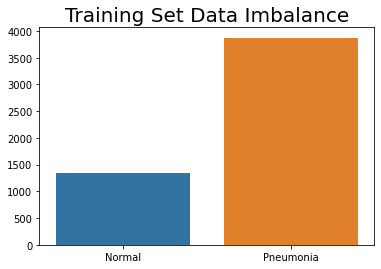

In [ ]:
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename) 
                     for filename in os.listdir(path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Imbalance', fontsize=20)
plt.show()

In [ ]:
train_samplesize

,Normal,Pneumonia
0,1341,3875


We can see that our data is imbalanced and we have 2534 less normal X-Ray images than the X-Ray images with Pneumonia. This is where we perform Data Augmentation.

## Data Augmentation

The idea of data augmentation is not that you need to create novel new images that can be added to your dataset.  Neural networks aren’t smart to begin with. To get more data, we just make minor alterations to our existing dataset. Minor changes such as flips or translations or rotations. Our neural network would think these are distinct images anyway.

In [ ]:
transformer = {
    'dataset1': transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
                                           ]),
    
    'dataset2' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=1),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.1,0.05), degrees=10),
                                            transform.ToTensor()
                                    
                                           ]),
    'dataset3' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=0.5),
                                            transform.RandomRotation(15),
                                            transform.RandomGrayscale(p=1),
                                            transform.RandomAffine(translate=(0.08,0.1), degrees=15),
                                            transform.ToTensor()
                                           ]),
}

In [ ]:
dataset1 = ImageFolder(path+'/train', 
                      transform=transformer['dataset1'])

dataset2 = ImageFolder(path+'/train', 
                      transform=transformer['dataset2'])

dataset3 = ImageFolder(path+'/train', 
                      transform=transformer['dataset3'])

norm1, _ = train_test_split(dataset2, test_size= 3875/(1341+3875), shuffle=False)
norm2, _ = train_test_split(dataset3, test_size= 4023/(1341+3875), shuffle=False)

dataset = ConcatDataset([dataset1, norm1, norm2])

len(dataset)

7750

In [ ]:
print(dataset1.classes)

['NORMAL', 'PNEUMONIA']


In [ ]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

## Data Exploration

We know look at how our data looks like.

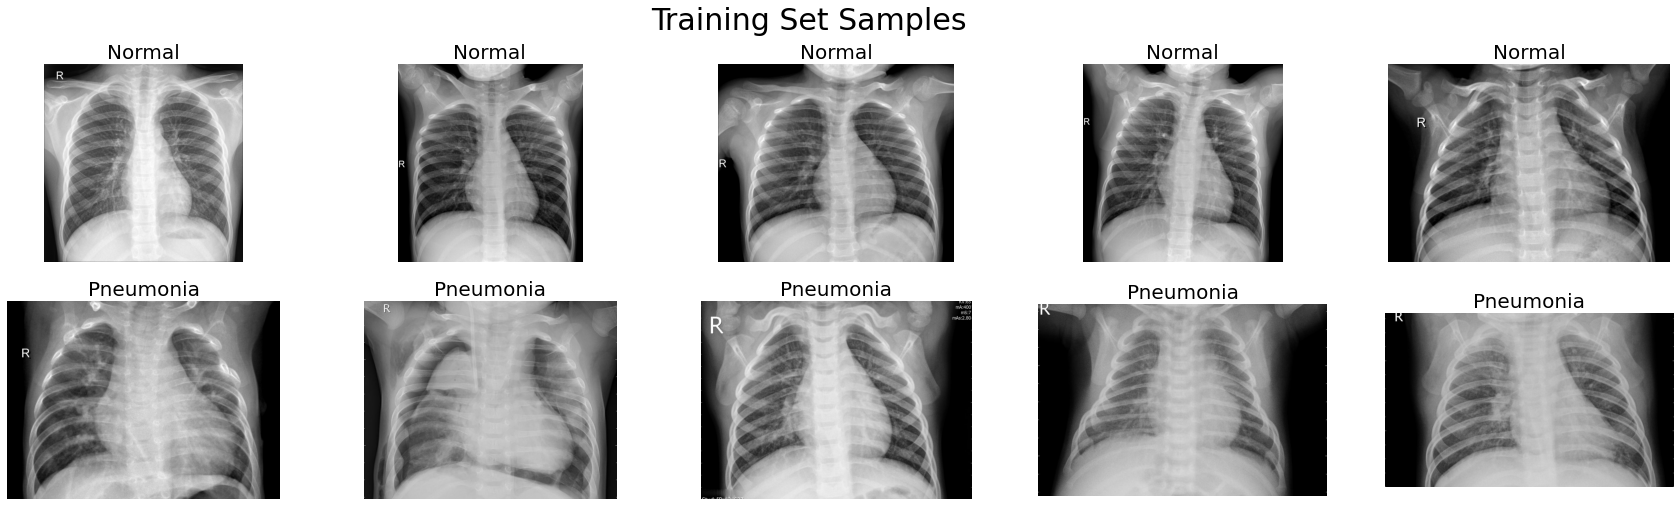

In [ ]:
rand_samples = random.sample([os.path.join(path+'/train/NORMAL', filename) 
                              for filename in os.listdir(path+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(path+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(path+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

In [ ]:
# set random seed so we get the same sampling every time for reproducibility

random_seed = 2020
torch.manual_seed(random_seed);

## Splitting the Dataset

I decided to split the training data into training and validation datasets eventhough we have 16 X-Ray images in the VALIDATION folder in the dataset. However, that is clearly not enough to evaluate our model.

In [ ]:
train_ds, val_ds = train_test_split(dataset, test_size=0.3, random_state=random_seed)
len(train_ds), len(val_ds)

(5425, 2325)

The data is wrapped into dataloaders. A dictionary is created with dataloggers so as to have quick access to them. Another dictionary is created for their sizes. Thehis will be useful to us for evaluating the model.

In [ ]:
batch_size=50

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
loaders = {'train':train_dl, 'val':val_dl}
dataset_sizes = {'train':len(train_ds), 'val':len(val_ds)}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let us look at the data after data augmentation.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


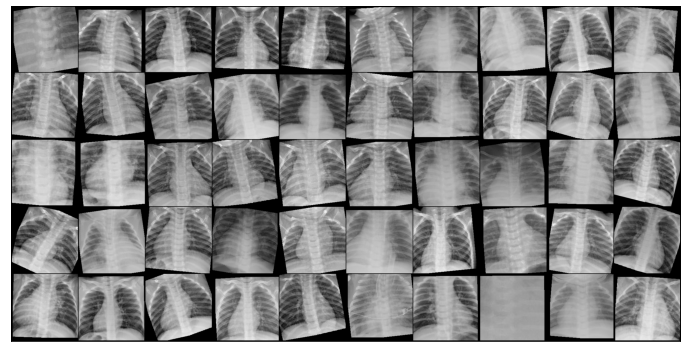

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

## Creating Our Model

We use the DenseNet-161 (Densely Connected Convolutional Neural Networks) pretrained on the weights of the ImageNet dataset. In DenseNets, every layer is connected to every other layer in a feed-forward fashion.

DenseNet alleviates the vanishing gradient problem which is introduced as the depth of the CNN increases. DenseNet also encourages feature reuse, and substantially reduces the number of parameters.

In [ ]:
model = torchvision.models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier.in_features

# We will also change the last layer, since it was originally trained in 1000 classes, and we have only 2 classes
model.classifier = nn.Linear(in_features, 2)

In [ ]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

Training function

In [ ]:
def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.001) # Only classifier specified in the Adam optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

In [ ]:
model.to(device)
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1/10
train - loss:0.2925308313787258, accuracy0.9028571428571428
val - loss:0.17049685056491565, accuracy0.9466666666666667
Time: 0.0m 54.38161659240723s
Epoch: 2/10
train - loss:0.16262494570099265, accuracy0.9454377880184331
val - loss:0.13427466831059867, accuracy0.9561290322580646
Time: 1.0m 51.3859703540802s
Epoch: 3/10
train - loss:0.13776765197240812, accuracy0.9541013824884793
val - loss:0.1206726864060407, accuracy0.9565591397849462
Time: 2.0m 52.13438057899475s
Epoch: 4/10
train - loss:0.11906316299592296, accuracy0.9612903225806452
val - loss:0.11186637617247079, accuracy0.9587096774193549
Time: 3.0m 52.40767979621887s
Epoch: 5/10
train - loss:0.10766588027850824, accuracy0.9647926267281106
val - loss:0.11099745040779473, accuracy0.9595698924731183
Time: 4.0m 52.828861236572266s
Epoch: 6/10
train - loss:0.1029244349230819, accuracy0.9673732718894009
val - loss:0.11251560464421267, accuracy0.963010752688172
Time: 5.0m 52.86560034751892s
Epoch: 7/10
train - loss:0.10300

In [ ]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model.to(device)
grad_clip = None
weight_decay = 1e-4
# weighted loss for data class imbalance
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1/10
train - loss:0.08455767155054116, accuracy0.9694009216589862
val - loss:0.07118438094133331, accuracy0.9763440860215054
Time: 2.0m 48.26257848739624s
Epoch: 2/10
train - loss:0.02730401132490769, accuracy0.9915207373271889
val - loss:0.0543186736833905, accuracy0.9802150537634409
Time: 5.0m 35.32124900817871s
Epoch: 3/10
train - loss:0.009937009326928543, accuracy0.9968663594470046
val - loss:0.0650416519192438, accuracy0.9793548387096774
Time: 8.0m 22.418078660964966s
Epoch: 4/10
train - loss:0.007617751525602065, accuracy0.9974193548387097
val - loss:0.06391383505736788, accuracy0.9819354838709677
Time: 11.0m 9.501726388931274s
Epoch: 5/10
train - loss:0.011545814325812236, accuracy0.9961290322580645
val - loss:0.07999219762922455, accuracy0.9840860215053764
Time: 13.0m 56.82562875747681s
Epoch: 6/10
train - loss:0.009919682918613362, accuracy0.9963133640552996
val - loss:0.057198629133723755, accuracy0.9853763440860215
Time: 16.0m 43.935616970062256s
Epoch: 7/10
train - 

TypeError: ignored

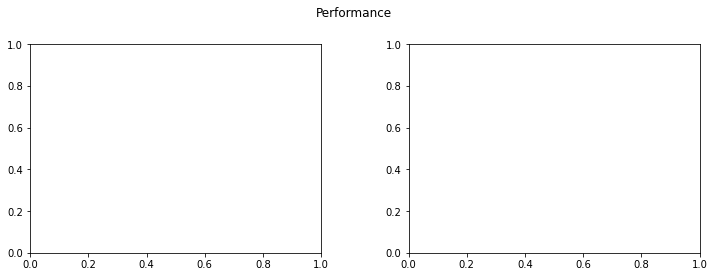

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs*2+1))
ax1.plot(epoch_list, accuracies['train'], label='Train Accuracy')
ax1.plot(epoch_list, accuracies['val'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs*2+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, losses['train'], label='Train Loss')
ax2.plot(epoch_list, losses['val'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs*2+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

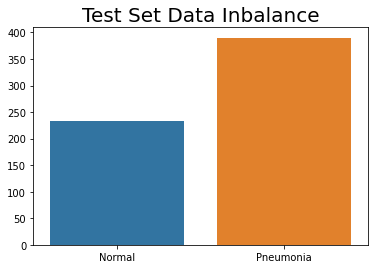

In [ ]:
test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/test/NORMAL', filename) 
                     for filename in os.listdir(path+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()


In [ ]:
def validation_step(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)                                      
        loss = F.cross_entropy(out, labels)                    
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}

In [ ]:
def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}  

In [ ]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [ ]:
testset = ImageFolder(path+'/test', 
                           transform=transform.Compose([transform.Resize(255),
                                                 transform.CenterCrop(224),                                                              
                                                 transform.ToTensor(),
                                                ]))

In [ ]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.7265, test_acc: 0.8968


<Figure size 432x288 with 0 Axes>

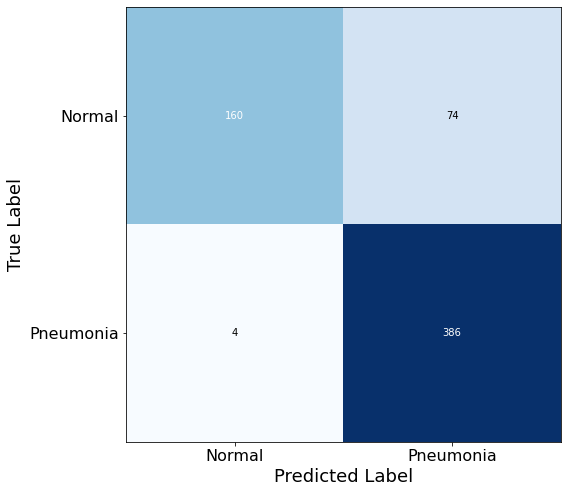

In [ ]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.88
Recall of the model is 0.99
Precision of the model is 0.84
F1 Score of the model is 0.91


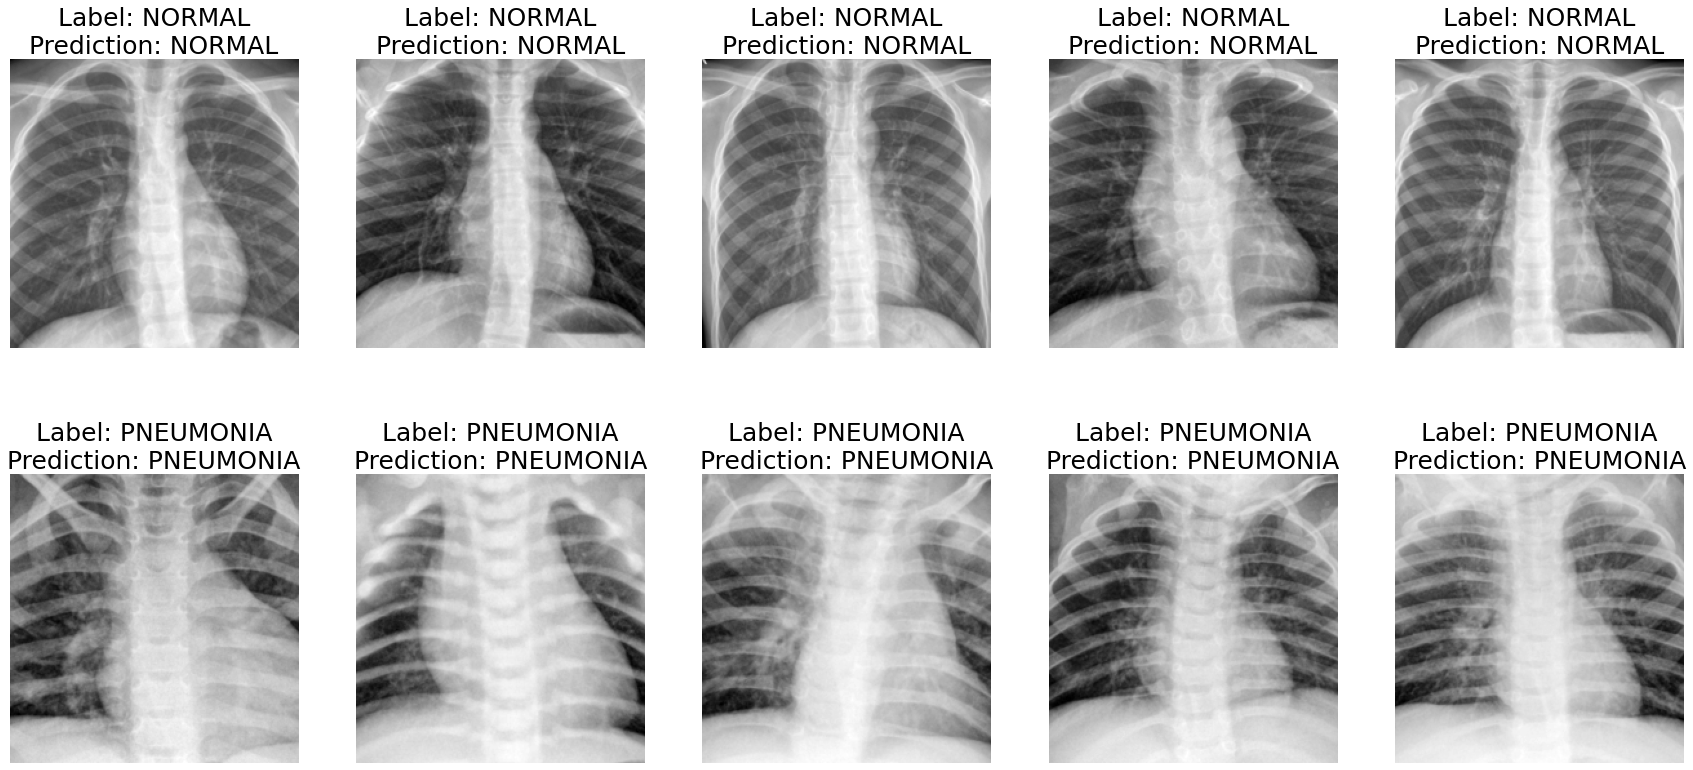

In [ ]:
# select 5 normal and 5 pneumonia images indices
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = testset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(testset.classes[label], 
                                    testset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')

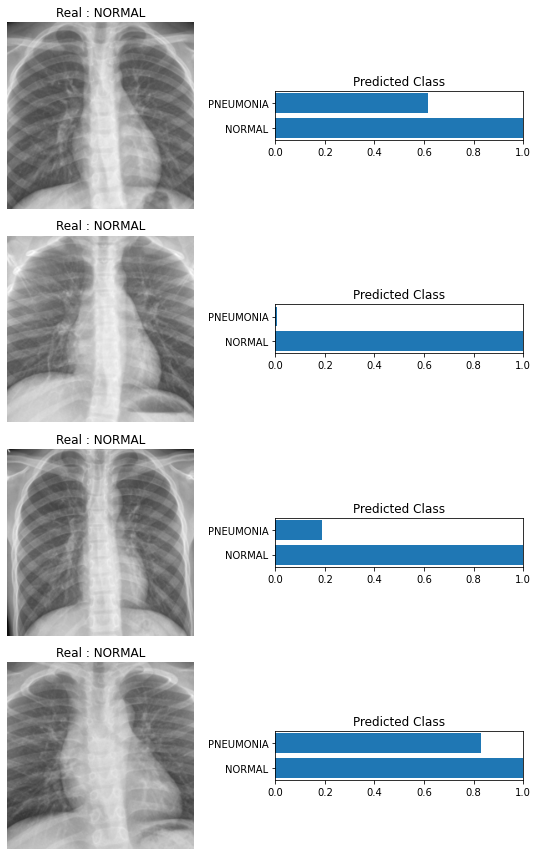

In [ ]:
fig, ax = plt.subplots(figsize=(8,12), ncols=2, nrows=4)

for row in range(4):
    img,label = testset[row]
    pred = torch.exp(model(img.to(device).unsqueeze(0)))
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)
    pred = pred.cpu().data.numpy().squeeze()
    ax[row][0].imshow(img.permute(1, 2, 0))
    ax[row][0].set_title('Real : {}'.format(class_name[label]))
    ax[row][0].axis('off')
    ax[row][1].barh(classes, pred)
    ax[row][1].set_aspect(0.1)
    ax[row][1].set_yticks(classes)
    ax[row][1].set_yticklabels(classes)
    ax[row][1].set_title('Predicted Class')
    ax[row][1].set_xlim(0, 1.)
    plt.tight_layout()
